In [3]:
import pandas as pd
import numpy as np
import scipy
import os
import os.path
from matplotlib import cm
from IPython.display import display, HTML

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import calendar

In [4]:
df_regLen = pd.read_csv("Data/regLen.csv").drop(["Unnamed: 0", "index"], axis = 1)



groupby_cycles = df_regLen.groupby(["cycle_index","user","cycle_number"]).mean()
user_cycle_df = pd.DataFrame(groupby_cycles.reset_index()[["cycle_index", "user", "cycle_number", "cycle_length"]])
user_cycle_df["cycle_length"] = user_cycle_df["cycle_length"].astype(int)
user_cycle_df.head()

,cycle_index,user,cycle_number,cycle_length
0,0,359,1,25
1,1,359,2,25
2,2,359,3,25
3,3,360,1,34
4,4,360,2,35


In [5]:
#missing days interpolated
md = pd.read_csv("Data/missingdays_interpolated.csv")
len(md.cycle_index.unique())

402

In [6]:
cc = pd.read_csv("Data/data_clean2.csv")
len(cc.cycle_index.unique())

172

In [8]:
def cycle_transform(df, value, save = True):

    value_ = df[["cycle_day", value, "cycle_index"]]

    value_zero = value_.pivot_table(index = "cycle_day", columns="cycle_index", values = value_).fillna(0)
    value_nan = value_.pivot_table(index = "cycle_day", columns="cycle_index", values = value_)

    if save == True:
        value_zero.to_csv("Data/"+value+"_zero.csv")
        value_nan.to_csv("Data/"+value+"_nan.csv")
    return value_zero, value_nan

In [9]:
hr29_norm_zero, hr29_norm_nan = cycle_transform(md[md.cycle_length == 29], "hr_norm", True)
hr29_norm_zero2, hr29_norm_nan2 = cycle_transform(cc[cc.cycle_length == 29], "hr_norm", True)

In [185]:
hr_norm_zero, hr_norm_nan = cycle_transform(md, "hr_norm", True)
hr_norm_zero2, hr_norm_nan2 = cycle_transform(cc, "hr_norm", True)

In [180]:
def DTWDistance(s1, s2):
    DTW={}
    w = 2
    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

## K-Means

In [153]:
import random

def k_means_clust(data,num_clust,num_iter):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        #print("counter:", counter)
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            #print("ind:", ind)
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
                #print("assignment: ", assignments)
            else:
                assignments[closest_clust]=[]

        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]

    return centroids, assignments

In [164]:
n_clusters = 9
n_iter = 20
centroids, assignments = k_means_clust(list(hr29_norm_zero.T.values), n_clusters, n_iter)

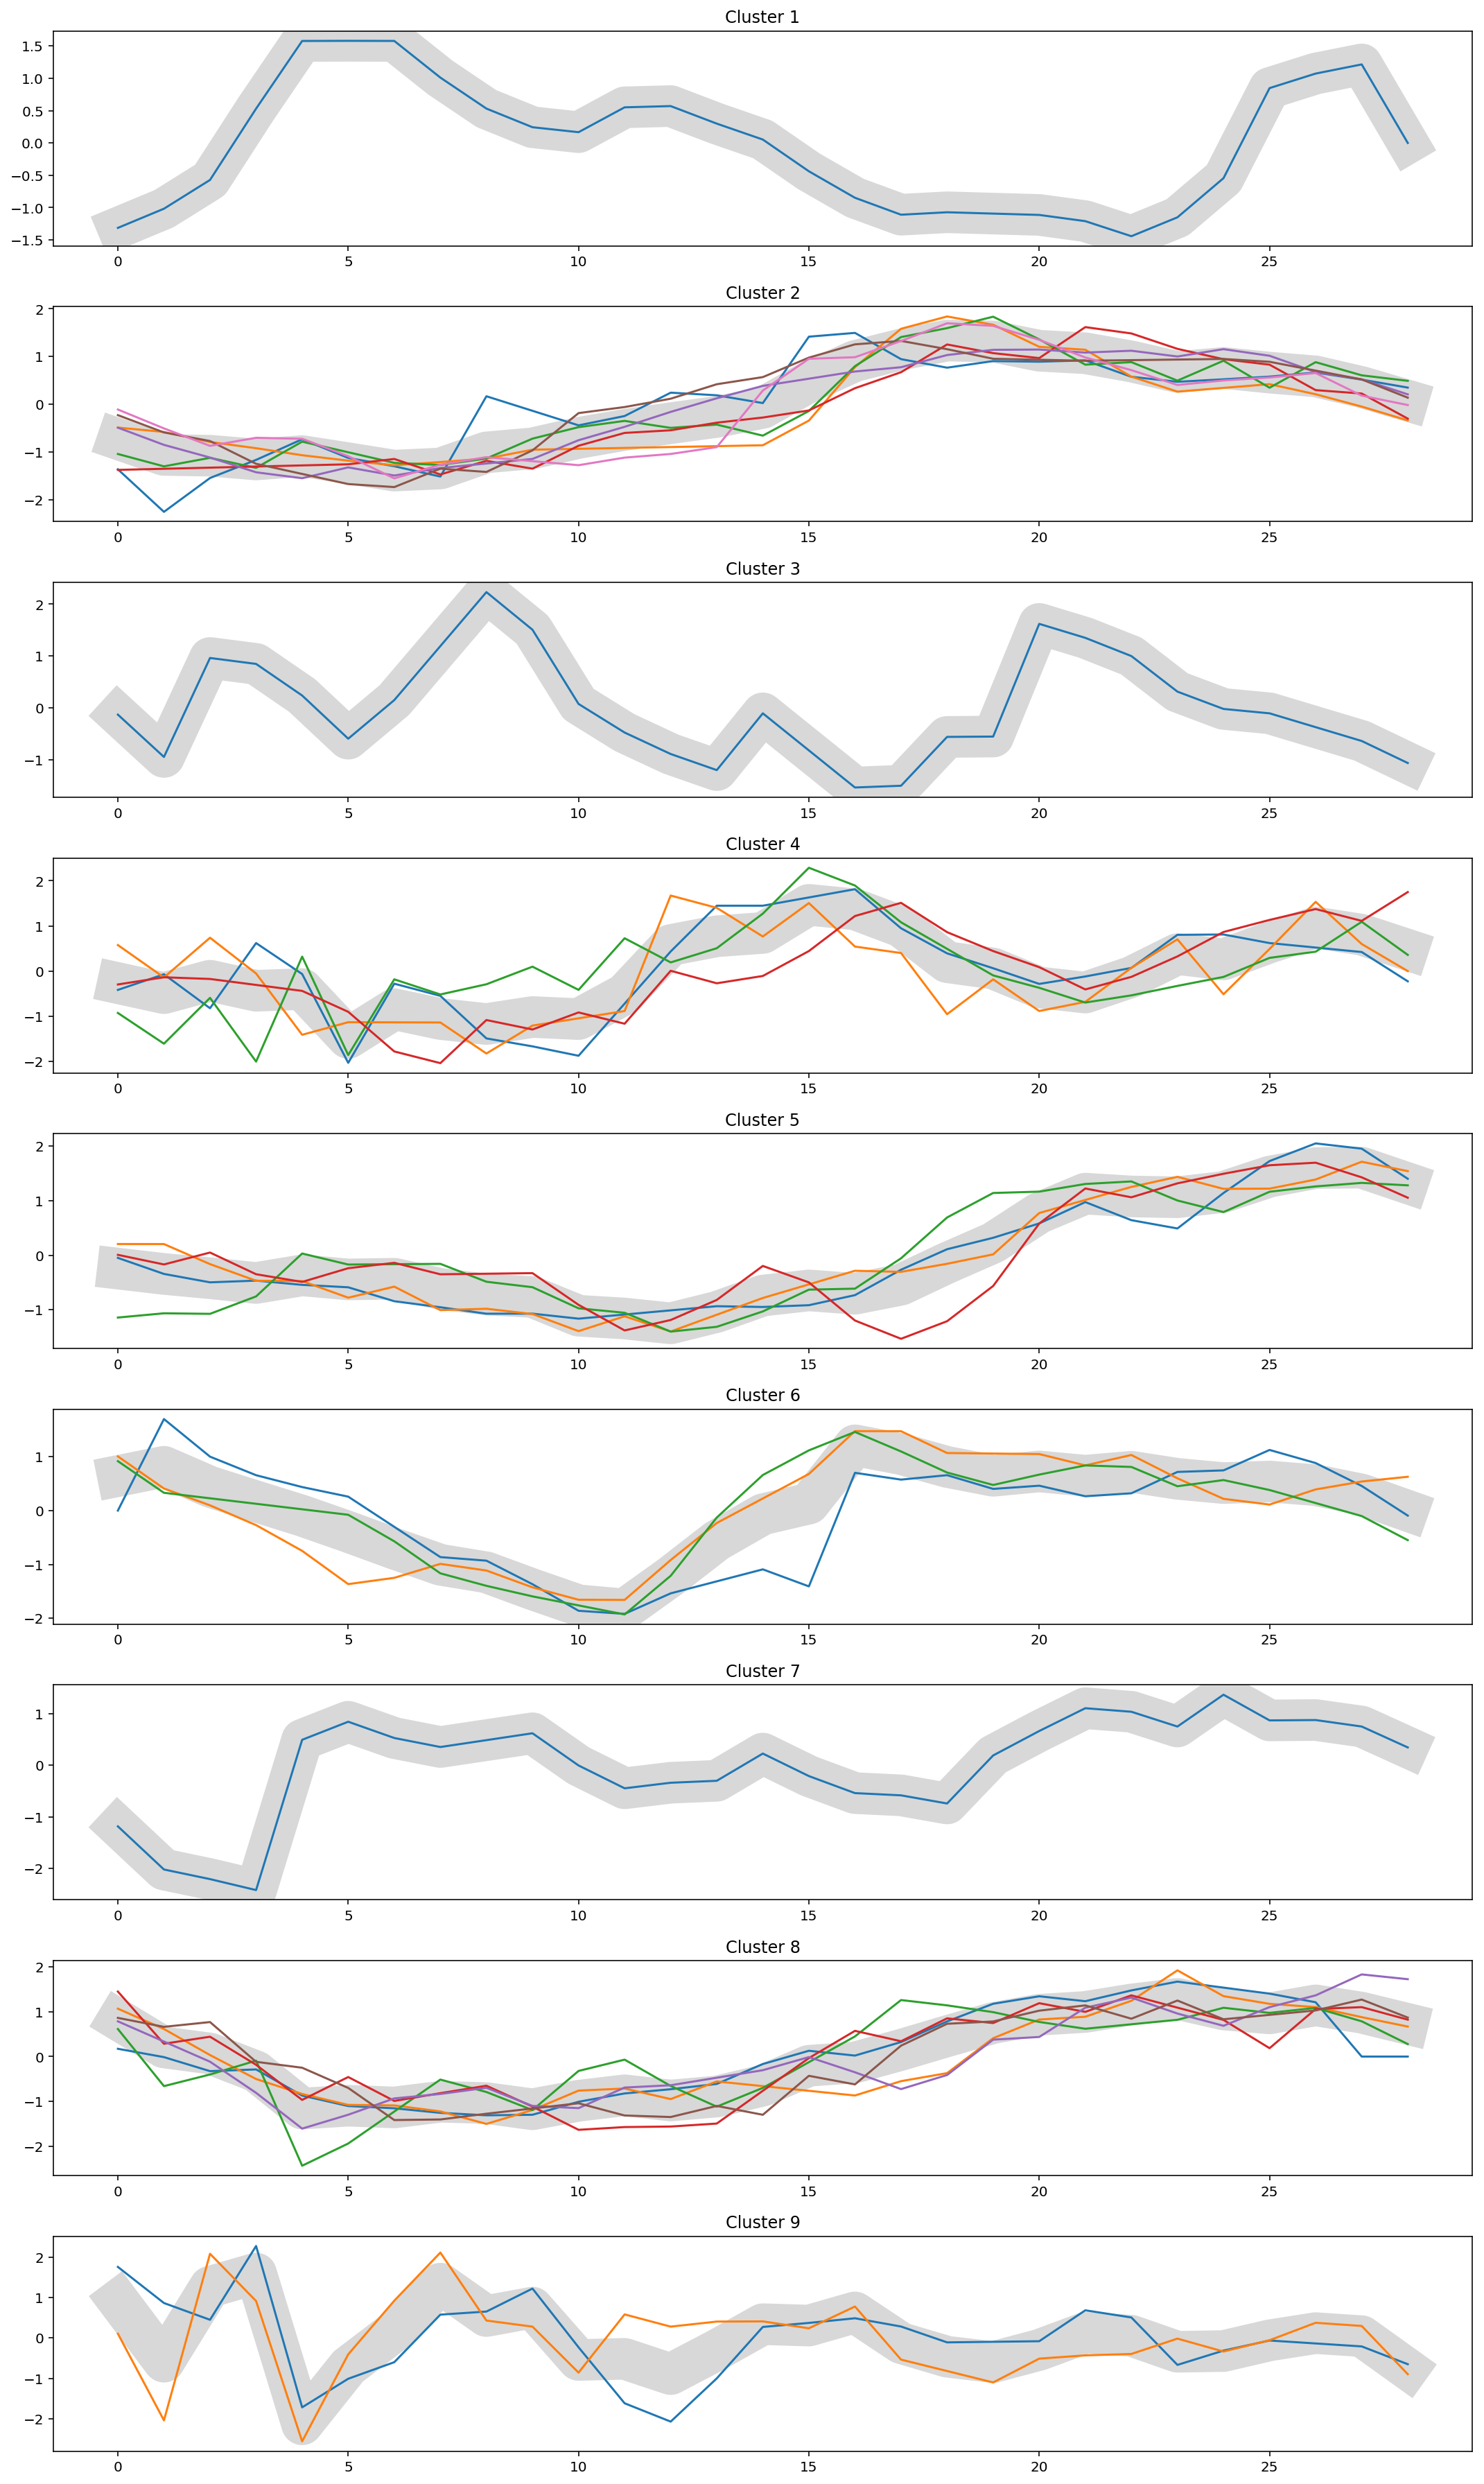

In [167]:
fig = plt.figure(figsize=(15,25))
for i in range(n_clusters):
    ax = fig.add_subplot(n_clusters,1,i+1)
    plt.plot(centroids[i],linewidth=30,c="gray" ,alpha = 0.3)
    columns = hr29_norm_zero.hr_norm.reset_index().drop("cycle_day", axis = 1).columns[assignments[i]]
    plt.plot(hr29_norm_zero.hr_norm.reset_index()[columns], alpha = 1)
    plt.title("Cluster "+str(i+1))
    
    plt.tight_layout()

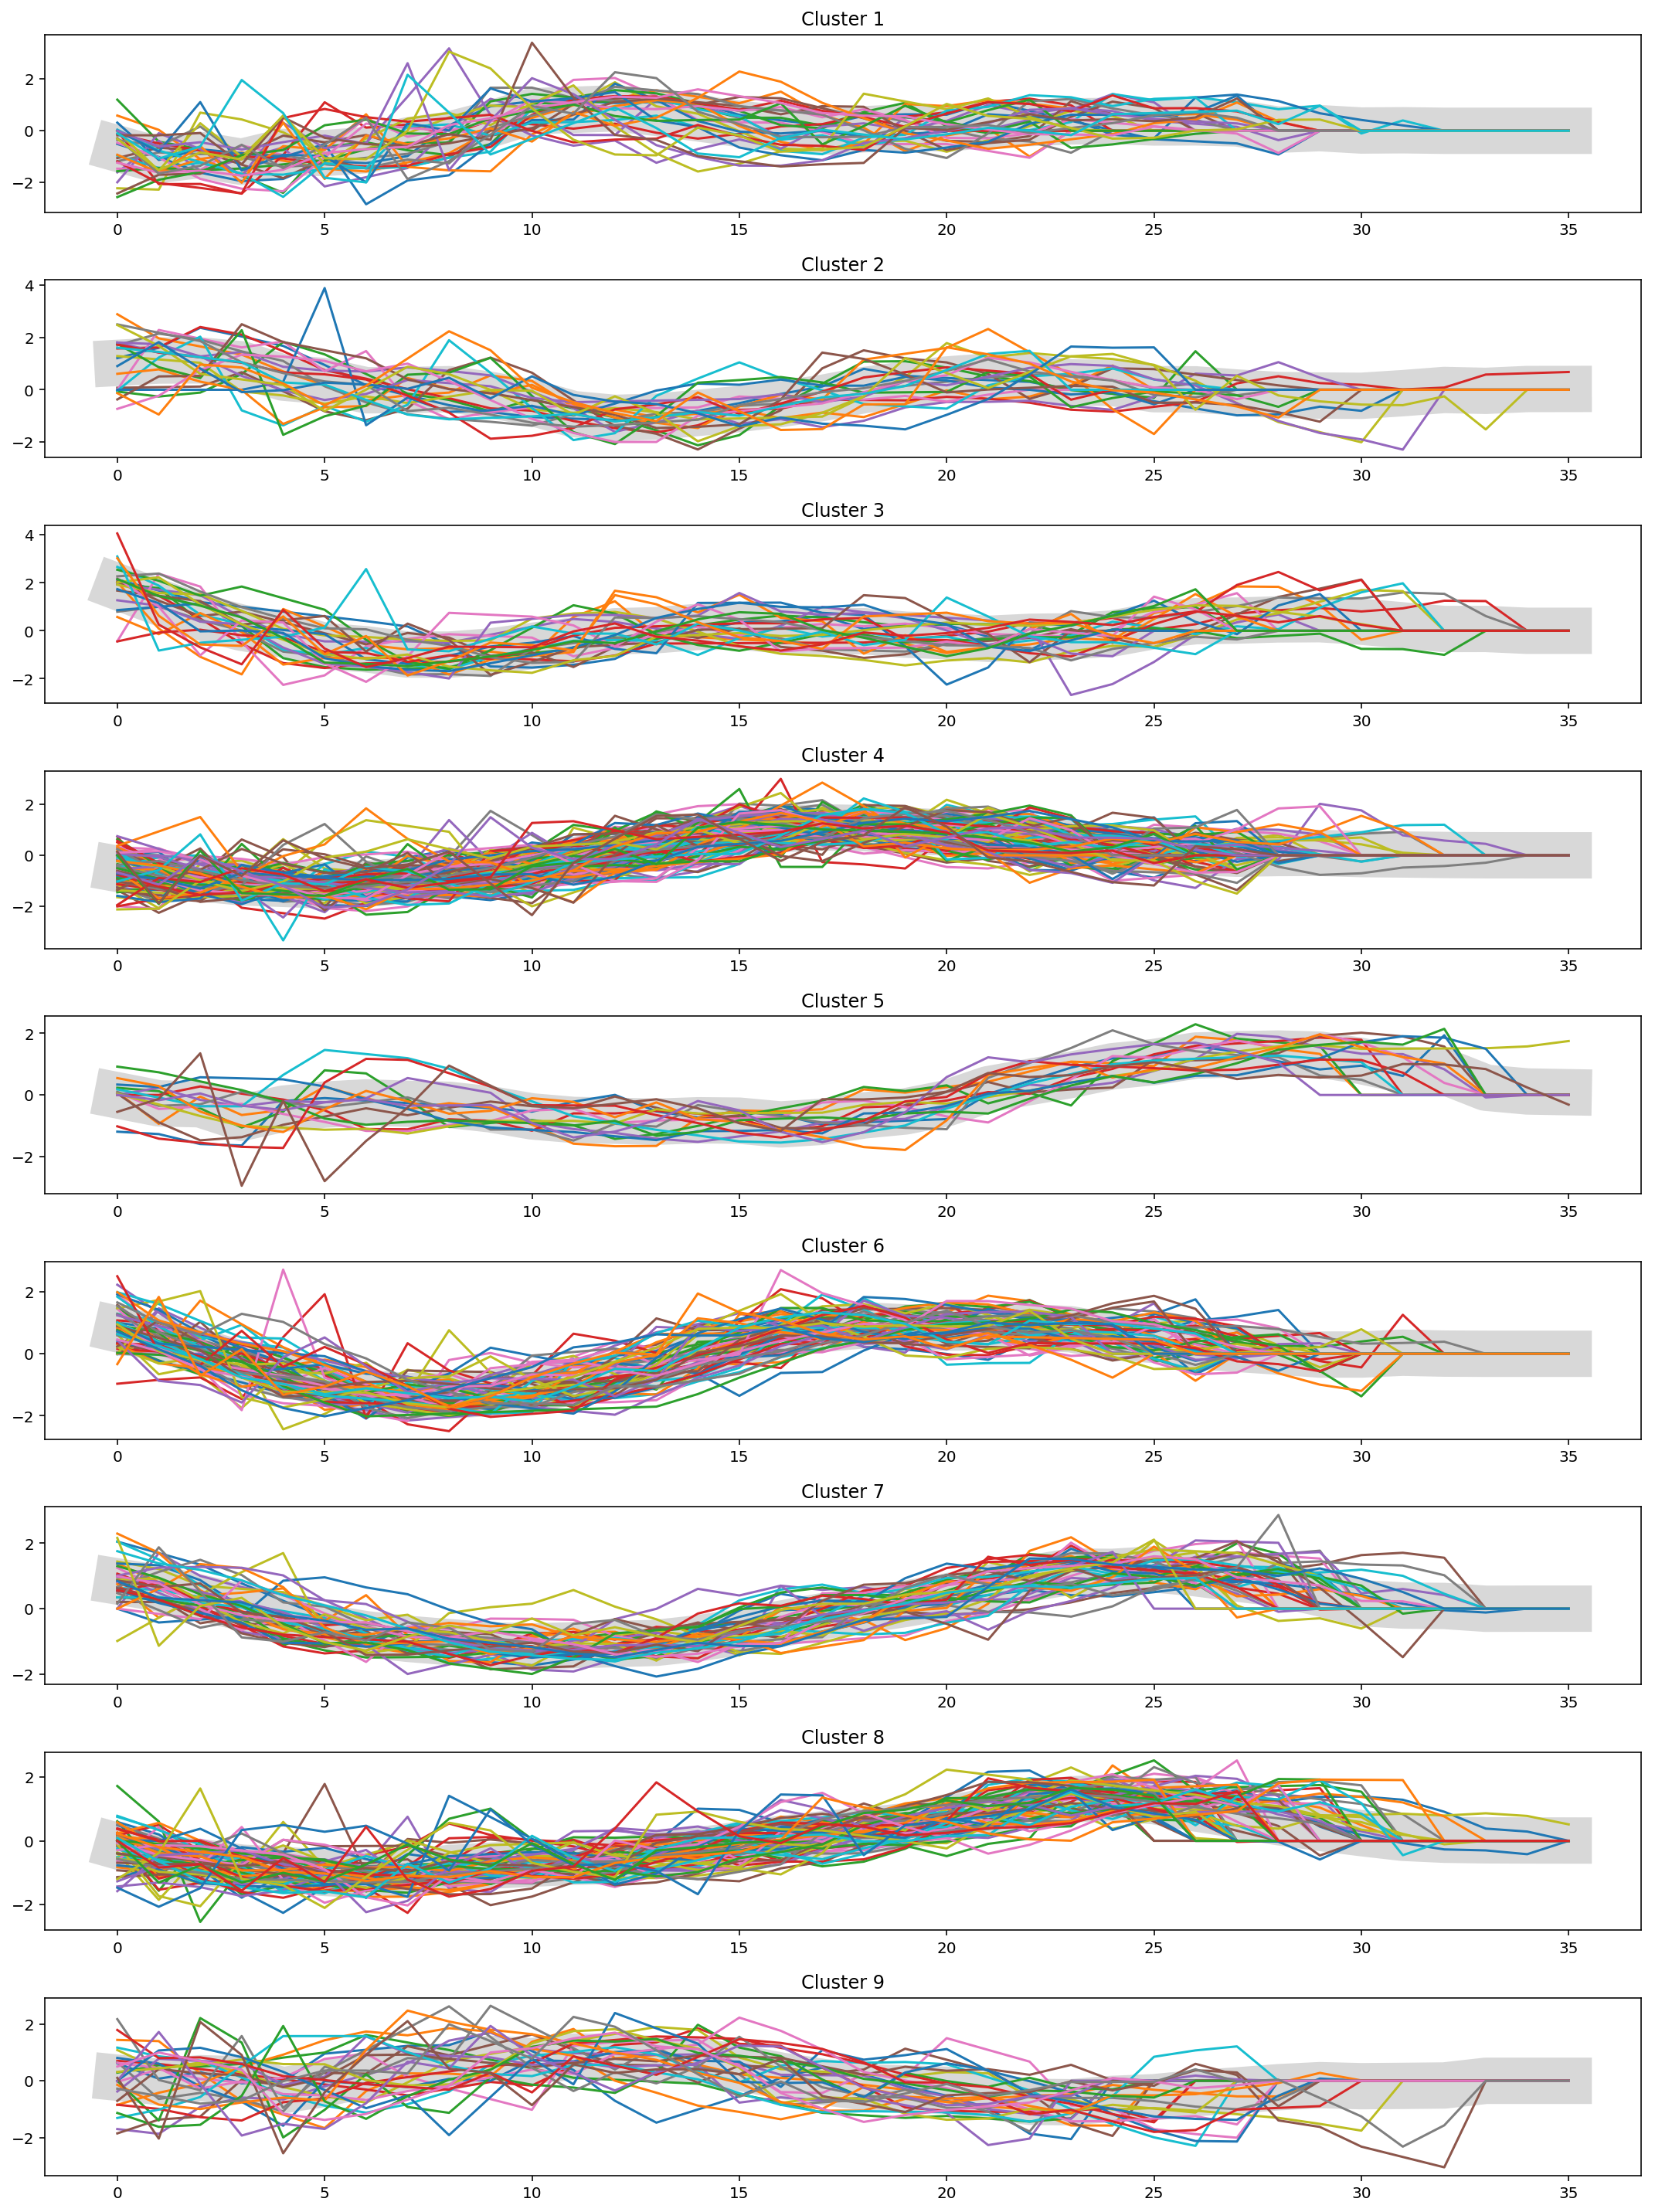

In [179]:
timeSeries = hr_norm_zero
n_clusters = 9
n_iter = 20
centroids, assignments = k_means_clust(list(timeSeries.T.values), n_clusters, n_iter)
fig = plt.figure(figsize=(15,20))
for i in range(n_clusters):
    ax = fig.add_subplot(n_clusters,1,i+1)
    plt.plot(centroids[i],linewidth=30,c="gray" ,alpha = 0.3)
    columns = timeSeries.hr_norm.reset_index().drop("cycle_day", axis = 1).columns[assignments[i]]
    for column in columns:
        plt.plot(timeSeries.hr_norm.reset_index()[column], alpha = 1)
    plt.title("Cluster "+str(i+1))
    
    plt.tight_layout()

In [244]:
from dtaidistance import dtw
def dtw_metric(x, y):
    distance = dtw.distance(x,y)
    return distance # correlation to distance: range 0 to 2

In [245]:
timeSeries = pd.concat([hr29_norm_zero, hr29_norm_zero2], axis=1, join_axes=[hr29_norm_zero.index])

s1 = timeSeries.hr_norm[93.0].values
s2 = timeSeries.hr_norm[23.0].values

In [246]:
dtw_metric(s1,s2)

3.6011212582492598